# HLS4ML with Pytorch using MLP

## Train a small 1 layer MLP 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torchinfo import summary
import tqdm.notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # fully connected layer, output 10 classes
        self.flatten = nn.Flatten(1,3)
        self.out = nn.Linear(28 * 28, 10)
    def forward(self, x):
        # flatten the output of conv2 to (batch_size, 28 * 28 * 3)
        x = self.flatten(x)     
        output = self.out(x)
        return output    # return x for visualization

In [4]:
# net = CNN()
model = MLP()
model.to(device)
summary(model, input_size=(100,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [100, 10]                 --
├─Flatten: 1-1                           [100, 784]                --
├─Linear: 1-2                            [100, 10]                 7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 0.79
Input size (MB): 0.31
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.35

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [6]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=False)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=False)

train_batch_size = 100
test_batch_size = 1

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=train_batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=test_batch_size,
                shuffle=False)

In [7]:
# PATH = './model/mnist_MLP.pth'
PATH = './model/mnist_MLP.pth'
TRAIN = not os.path.isfile(PATH)
if TRAIN:
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in tqdm.tqdm(enumerate(train_loader, 0), total = len(train_loader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 500 == 0:    # print every 100 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    save_model = model.to('cpu')
    torch.save(save_model, PATH)
    print('Finished Training')
else:
    model = torch.load(PATH)
model.to(device)

  0%|          | 0/600 [00:00<?, ?it/s]

[1,     1] loss: 0.001
[1,   501] loss: 0.302


  0%|          | 0/600 [00:00<?, ?it/s]

[2,     1] loss: 0.000
[2,   501] loss: 0.160


  0%|          | 0/600 [00:00<?, ?it/s]

[3,     1] loss: 0.000
[3,   501] loss: 0.132


  0%|          | 0/600 [00:00<?, ?it/s]

[4,     1] loss: 0.000
[4,   501] loss: 0.119


  0%|          | 0/600 [00:00<?, ?it/s]

[5,     1] loss: 0.000
[5,   501] loss: 0.112


  0%|          | 0/600 [00:00<?, ?it/s]

[6,     1] loss: 0.000
[6,   501] loss: 0.106


  0%|          | 0/600 [00:00<?, ?it/s]

[7,     1] loss: 0.000
[7,   501] loss: 0.102


  0%|          | 0/600 [00:00<?, ?it/s]

[8,     1] loss: 0.000
[8,   501] loss: 0.099


  0%|          | 0/600 [00:00<?, ?it/s]

[9,     1] loss: 0.000
[9,   501] loss: 0.097


  0%|          | 0/600 [00:00<?, ?it/s]

[10,     1] loss: 0.000
[10,   501] loss: 0.094
Finished Training


MLP(
  (flatten): Flatten(start_dim=1, end_dim=3)
  (out): Linear(in_features=784, out_features=10, bias=True)
)

## Evaluate Pytorch Model

In [8]:
correct = 0
total = 0
y_true = []
y_pred = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.append(labels.numpy())
        y_pred.append(predicted.numpy())

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 90 %


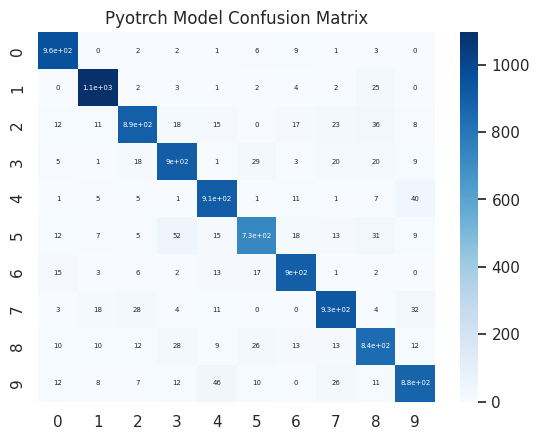

In [9]:
confusion_mtx = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(confusion_mtx, range(len(confusion_mtx)), range(len(confusion_mtx)))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 5}) # font size
plt.title("Pyotrch Model Confusion Matrix")
plt.show()

## Convert model to HLS

### Export Pytorch model to (Q)ONNX

In [10]:
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.util.cleanup import cleanup_model
from qonnx.transformation.gemm_to_matmul import GemmToMatMul

In [11]:
# Input to the model
x = next(iter(test_loader))[0]
x = x.to(device)
torch_out = model(x)

# Export the model
torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}}
                 )

In [12]:
onnx_model = ModelWrapper("super_resolution.onnx")
onnx_model = cleanup_model(onnx_model)
onnx_model = onnx_model.transform(GemmToMatMul())
onnx_model = cleanup_model(onnx_model)
onnx_model.save("super_resulution_noGemm_clean.onnx") 

/opt/conda/envs/mnist_37/lib/python3.7/site-packages/qonnx/transformation/gemm_to_matmul.py:58: UserWarning: The GemmToMatMul transformation only offers explicit support for version 9 of the Gemm node, but the ONNX version of the supplied model is 10. Thus the transformation may fail or return incomplete results.
  f"The GemmToMatMul transformation only offers explicit support "


In [13]:
import hls4ml

WARN: Unable to import optimizer(s) from qkeras.py: No module named 'tensorflow'
WARN: Unable to import optimizer(s) from quantization_templates.py: No module named 'tensorflow'
WARN: Unable to import optimizer(s) from quantization_templates.py: No module named 'tensorflow'
WARN: Unable to import optimizer(s) from quantization_templates.py: No module named 'tensorflow'


/opt/conda/envs/mnist_37/lib/python3.7/site-packages/hls4ml/converters/__init__.py:29: UserWarning: WARNING: Tensorflow converter is not enabled!
  warnings.warn("WARNING: Tensorflow converter is not enabled!")


In [14]:
model_name = "super_resulution_noGemm_clean.onnx"

config = hls4ml.utils.config_from_onnx_model(model_name, granularity='model')
hls_model = hls4ml.converters.convert_from_onnx_model(model_name, hls_config=config)
hls_model.compile()

Interpreting Model ...
Output layers:  ['Add_0']
Input shape: (1, 1, 28, 28)
Topology:
Layer name: Flatten_0, layer type: Reshape, current shape: [(1, 1, 28, 28)]
Layer name: MatMul_0, layer type: MatMul, current shape: [(1, 784), (784, 10)]
Layer name: Add_0, layer type: Merge, current shape: [(1, 10), (10,)]
Creating HLS model
Writing HLS project
Done


In [15]:
correct = 0
total = 0
sample = next(iter(test_loader))
X_test = [i for i in sample[0]]
y_test = [i for i in sample[1]]
y_true = []
y_pred = []
# since we're not training, we don't need to calculate the gradients for our outputs
for data in test_loader:
    feature = data[0].numpy()
    target = data[1].numpy()
#     images, labels = images.numpy(), labels.numpy()
    # calculate outputs by running images through the network
    outputs = hls_model.predict(feature)
    # the class with the highest energy is what we choose as prediction
    predicted = np.argmax(outputs)
    total += 1
    correct += (predicted == target).sum().item()
    y_true.append(target)
    y_pred.append(predicted)

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 90 %


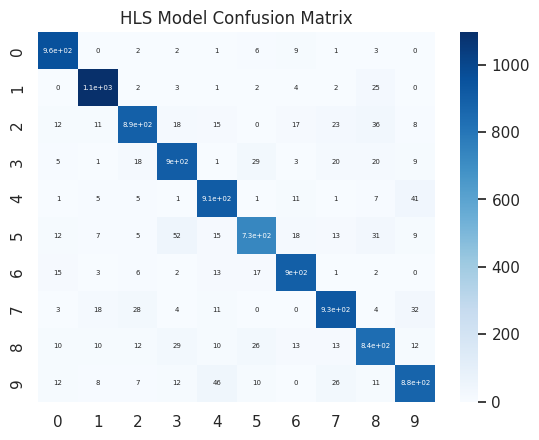

In [16]:
confusion_mtx = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(confusion_mtx, range(len(confusion_mtx)), range(len(confusion_mtx)))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, cmap="Blues", annot_kws={"size": 5}) # font size
plt.title("HLS Model Confusion Matrix")
plt.show()